# Time Series Data: Predict Temperature

The columns of the data correspond to the
  - year
  - month
  - day
  - hour
  - temp
  - dew_temp
  - pressure
  - wind_angle
  - wind_speed
  - sky_code
  - rain_hour
  - rain_6hour
  - city


In [4]:
def load_stream(stream):
    return pd.read_csv(stream, sep=' +', engine='python',
                         names=['year', 'month', 'day', 'hour', 'temp',
                                'dew_temp', 'pressure', 'wind_angle', 
                                'wind_speed', 'sky_code', 'rain_hour',
                                'rain_6hour', 'city'])

In [25]:
df = load_stream(gzip.open('train.txt.gz', 'rt'))

In [26]:
df.shape

(525869, 13)

In [27]:
df['date']=pd.to_datetime(df[["year", "month", "day",'hour']])
df=df.set_index('date')
df.head()

,year,month,day,hour,temp,dew_temp,pressure,wind_angle,wind_speed,sky_code,rain_hour,rain_6hour,city
date,,,,,,,,,,,,,
2000-01-01 00:00:00,2000,1,1,0,-11,-72,10197,220,26,4,0,0,bos
2000-01-01 01:00:00,2000,1,1,1,-6,-78,10206,230,26,2,0,-9999,bos
2000-01-01 02:00:00,2000,1,1,2,-17,-78,10211,230,36,0,0,-9999,bos
2000-01-01 03:00:00,2000,1,1,3,-17,-78,10214,230,36,0,0,-9999,bos
2000-01-01 04:00:00,2000,1,1,4,-17,-78,10216,230,36,0,0,-9999,bos


In [28]:
df['julian'] = df.index.to_julian_date()
df.head()

,year,month,day,hour,temp,dew_temp,pressure,wind_angle,wind_speed,sky_code,rain_hour,rain_6hour,city,julian
date,,,,,,,,,,,,,,
2000-01-01 00:00:00,2000,1,1,0,-11,-72,10197,220,26,4,0,0,bos,2.451544e+06
2000-01-01 01:00:00,2000,1,1,1,-6,-78,10206,230,26,2,0,-9999,bos,2.451545e+06
2000-01-01 02:00:00,2000,1,1,2,-17,-78,10211,230,36,0,0,-9999,bos,2.451545e+06
2000-01-01 03:00:00,2000,1,1,3,-17,-78,10214,230,36,0,0,-9999,bos,2.451545e+06
2000-01-01 04:00:00,2000,1,1,4,-17,-78,10216,230,36,0,0,-9999,bos,2.451545e+06


In [29]:
df['temp'].describe(),df['dew_temp'].describe()

(count    525869.000000
 mean        -76.307965
 std        1405.382671
 min       -9999.000000
 25%          33.000000
 50%         122.000000
 75%         206.000000
 max         406.000000
 Name: temp, dtype: float64,
 count    525869.000000
 mean       -142.707722
 std        1399.640272
 min       -9999.000000
 25%         -30.000000
 50%          61.000000
 75%         144.000000
 max         272.000000
 Name: dew_temp, dtype: float64)

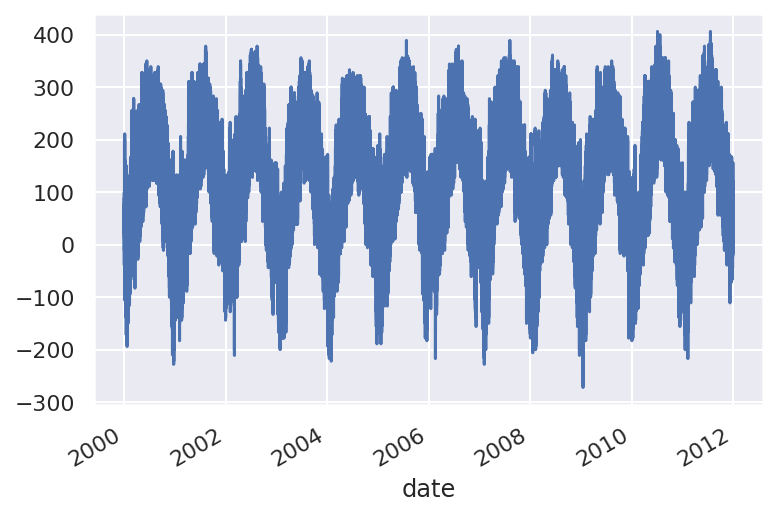

In [32]:
df['temp'].plot()

The temperature is reported in tenths of a degree Celsius.  However, not all the values are valid.  Examine the data, and remove the invalid rows.

In [61]:
for c in df.columns:
    df = df[df[c]!=-9999]
df.shape

(39228, 14)

In [62]:
df['city'].unique()

array(['bos', 'bal', 'chi', 'nyc', 'phi'], dtype=object)

We will focus on using the temporal elements to predict the temperature.


## Per city model


It makes sense for each city to have it's own model.  Build a "group-by" estimator that takes an estimator factory as an argument and builds the resulting "group-by" estimator on each city.  That is, `fit` should create and fit a model per city, while the `predict` method should look up the corresponding model and perform a predict on each.  An estimator factory is something that returns an estimator each time it is called.  It could be a function or a class.

In [343]:
from sklearn import base

class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, column, estimator_factory):
        # column is the value to group by; estimator_factory can be
        # called to produce estimatorsy
        self.column = column
        self.estimator_factory = estimator_factory
        self.estimators = {}
    
    def fit(self, X, y):
        # Create an estimator and fit it with the portion in each group
        lis=df[self.column].unique()
        for l in lis:
            group = X[X[self.column]==l][['month','hour']]            
            y_group = X[X[self.column]==l]['temp']
            self.estimators[l] = self.estimator_factory().fit(group,y_group)  
            
        return self

    def predict(self, X):
        # Call the appropriate predict method for each row of X
        predictions = []
        for line in X:
            inputs = line.split()
            city = inputs[-1]
            
            #lis_0=[0]*12            
            month = int(inputs[1])
            hour = int(inputs[3])
            #lis_0[month]=1
            #lis_0.append(hour)
            #point = np.array(lis_0).reshape(-1, 1)            
            point=[[month,hour]]            
            predictions.append(ests[city].predict(point))
        return [int(p) for p in predictions]

In [214]:
from sklearn.linear_model import Ridge
def est_factory():
    return RandomForestRegressor() 

In [221]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df['temp'], test_size=0.2, random_state=42)

In [222]:
GroupbyEstimator('city', est_factory()).fit(X_train, y_train)

GroupbyEstimator(column='city',
                 estimator_factory=RandomForestRegressor(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         criterion='mse',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                     

In [219]:
txt='2000 01 01 00   -11   -72 10197   220    26     4     0     0 bos'
txt.split()[-1]
int(txt.split()[1])
int(txt.split()[3])

0

In [220]:
GroupbyEstimator('city', est_factory()).predict([txt])

[-4.840675510153518]

## Month/hour model

Seasonal features are nice because they are relatively safe to extrapolate into the future. There are two ways to handle seasonality.  

The simplest (and perhaps most robust) is to have a set of indicator variables. That is, make the assumption that the temperature at any given time is a function of only the month of the year and the hour of the day, and use that to predict the temperature value.

In [344]:
from sklearn.ensemble import RandomForestRegressor
def season_factory():
    return RandomForestRegressor() # A single estimator or a pipeline

season_model = GroupbyEstimator('city', season_factory()).fit(df, df['temp'])

## Fourier model

Since we know that temperature is roughly sinusoidal, we know that a reasonable model might be

$$ y_t = y_0 \sin\left(2\pi\frac{t - t_0}{T}\right) + \epsilon $$

where $k$ and $t_0$ are parameters to be learned and $T$ is one year for seasonal variation.  While this is linear in $y_0$, it is not linear in $t_0$. However, we know from Fourier analysis, that the above is
equivalent to

$$ y_t = A \sin\left(2\pi\frac{t}{T}\right) + B \cos\left(2\pi\frac{t}{T}\right) + \epsilon $$

which is linear in $A$ and $B$.

Create a model containing sinusoidal terms on one or more time scales, and fit it to the data using a linear regression.

In [360]:
df['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011])

In [348]:
df.head()

,year,month,day,hour,temp,dew_temp,pressure,wind_angle,wind_speed,sky_code,rain_hour,rain_6hour,city,julian,Month
date,,,,,,,,,,,,,,,
2000-01-01 00:00:00,2000,1,1,0,-11,-72,10197,220,26,4,0,0,bos,2451544.50,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
2000-01-01 06:00:00,2000,1,1,6,-28,-83,10219,230,26,0,0,0,bos,2451544.75,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
2000-01-01 12:00:00,2000,1,1,12,-22,-67,10244,240,26,4,0,0,bos,2451545.00,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
2000-01-01 18:00:00,2000,1,1,18,83,-22,10216,230,72,4,0,0,bos,2451545.25,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
2000-01-02 00:00:00,2000,1,2,0,56,-11,10228,220,62,2,0,0,bos,2451545.50,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."


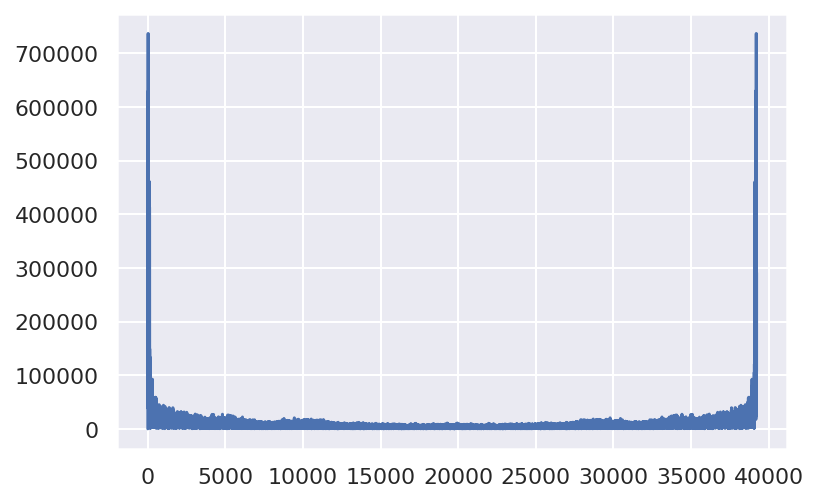

In [350]:
import scipy.fft
import matplotlib.pyplot as plt

fft = scipy.fft.fft((df.temp - df.temp.mean()).values)
plt.plot(np.abs(fft))

In [352]:
df['const'] = 1
df['sin(year)'] = np.sin(df['julian'] / 365.25 * 2 * np.pi)
df['cos(year)'] = np.cos(df['julian'] / 365.25 * 2 * np.pi)
df['sin(6mo)'] = np.sin(df['julian'] / (365.25 / 2) * 2 * np.pi)
df['cos(6mo)'] = np.cos(df['julian'] / (365.25 / 2) * 2 * np.pi)
df['sin(day)'] = np.sin(df.index.hour / 24.0 * 2* np.pi)
df['cos(day)'] = np.cos(df.index.hour / 24.0 * 2* np.pi)

In [354]:
bos=df[df['city']=='bos']
bos.head()

,year,month,day,hour,temp,dew_temp,pressure,wind_angle,wind_speed,sky_code,...,city,julian,Month,const,sin(year),cos(year),sin(6mo),cos(6mo),sin(day),cos(day)
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,2000,1,1,0,-11,-72,10197,220,26,4,...,bos,2451544.50,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ...",1,-0.230151,0.973155,-0.447945,0.894061,0.000000e+00,1.000000e+00
2000-01-01 06:00:00,2000,1,1,6,-28,-83,10219,230,26,0,...,bos,2451544.75,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ...",1,-0.225964,0.974136,-0.440238,0.897881,1.000000e+00,6.123234e-17
2000-01-01 12:00:00,2000,1,1,12,-22,-67,10244,240,26,4,...,bos,2451545.00,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ...",1,-0.221772,0.975099,-0.432499,0.901634,1.224647e-16,-1.000000e+00
2000-01-01 18:00:00,2000,1,1,18,83,-22,10216,230,72,4,...,bos,2451545.25,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ...",1,-0.217577,0.976043,-0.424728,0.905321,-1.000000e+00,-1.836970e-16
2000-01-02 00:00:00,2000,1,2,0,56,-11,10228,220,62,2,...,bos,2451545.50,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ...",1,-0.213377,0.976970,-0.416926,0.908940,0.000000e+00,1.000000e+00


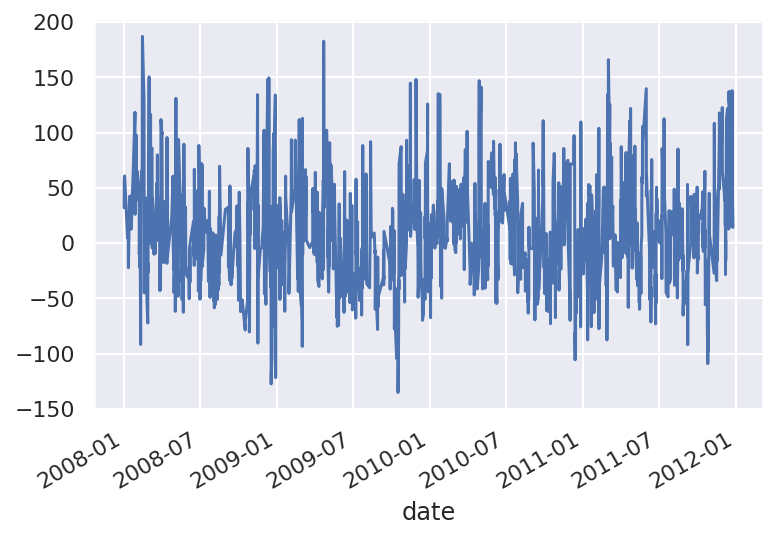

In [375]:
cut_year = 2008

train = bos[bos.index.year < cut_year].dropna(how='any')
test  = bos[bos.index.year >= cut_year].dropna(how='any')
regress = LinearRegression().fit( 
        X=train[['sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']], 
        y=train['temp'])

test['Predicted_Value'] = regress.predict(X=test[['sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']] )

(test['Goal'] - test['Predicted_Value']).plot()

In [367]:
txt='2000 01 01 00   -11   -72 10197   220    26     4     0     0 bos'
list_vals=['2000 01 01 00   -11   -72 10197   220    26     4     0     0 bos\n','2000 01 01 00   -11   -72 10197   220    26     4     0     0 bos\n','2000 01 01 00   -11   -72 10197   220    26     4     0     0 bos\n']
def load_stream(stream):
    return pd.read_csv(stream, sep=' +', engine='python',
                         names=['year', 'month', 'day', 'hour', 'temp',
                                'dew_temp', 'pressure', 'wind_angle', 
                                'wind_speed', 'sky_code', 'rain_hour',
                                'rain_6hour', 'city'])

In [368]:
from io import StringIO

In [376]:
row=pd.read_csv(StringIO('\n'.join(list_vals)), delim_whitespace=True,names=['year', 'month', 'day', 'hour', 'temp',
                                'dew_temp', 'pressure', 'wind_angle', 
                                'wind_speed', 'sky_code', 'rain_hour',
                                'rain_6hour', 'city'])
row

,year,month,day,hour,temp,dew_temp,pressure,wind_angle,wind_speed,sky_code,rain_hour,rain_6hour,city
0,2000,1,1,0,-11,-72,10197,220,26,4,0,0,bos
1,2000,1,1,0,-11,-72,10197,220,26,4,0,0,bos
2,2000,1,1,0,-11,-72,10197,220,26,4,0,0,bos


In [397]:
for index,r in row.iterrows():
    d=r['city']
    da=r[['pressure', 'wind_angle','wind_speed', 'sky_code', 'rain_hour']].values.reshape(1,-1)
    print(d)
    print(da)

bos
[[10197 220 26 4 0]]
bos
[[10197 220 26 4 0]]
bos
[[10197 220 26 4 0]]


In [371]:
def load_string(lis):
    return pd.read_csv(StringIO('\n'.join(list_vals)), delim_whitespace=True,names=['year', 'month', 'day', 'hour', 'temp',
                                'dew_temp', 'pressure', 'wind_angle', 
                                'wind_speed', 'sky_code', 'rain_hour',
                                'rain_6hour', 'city'])

In [381]:
lambda x: load_string(x)

<function __main__.<lambda>(x)>

In [458]:
def load_string(lis):
    return pd.read_csv(StringIO('\n'.join(lis)), delim_whitespace=True,names=['year', 'month', 'day', 'hour', 'temp',
                            'dew_temp', 'pressure', 'wind_angle', 
                            'wind_speed', 'sky_code', 'rain_hour',
                            'rain_6hour', 'city'])

class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, column, estimator_factory):
        # column is the value to group by; estimator_factory can be
        # called to produce estimatorsy
        self.column = column
        self.estimator_factory = estimator_factory
        self.estimators = {}
    
    def fit(self, X, y):
        # Create an estimator and fit it with the portion in each group
        lis=X[self.column].unique()
        X['julian'] = X.index.to_julian_date()
        X['sin(year)'] = np.sin(X['julian'] / 365.25 * 2 * np.pi)
        X['cos(year)'] = np.cos(X['julian'] / 365.25 * 2 * np.pi)
        X['sin(6mo)'] = np.sin(X['julian'] / (365.25 / 2) * 2 * np.pi)
        X['cos(6mo)'] = np.cos(X['julian'] / (365.25 / 2) * 2 * np.pi)
        X['sin(day)'] = np.sin(X.index.hour / 24.0 * 2* np.pi)
        X['cos(day)'] = np.cos(X.index.hour / 24.0 * 2* np.pi)
        
        for l in lis:
            estimator[l] = self.estimator_factory
            group = X[X[self.column]==l][['sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']]
            
            y_group = X[X[self.column]==l]['temp']
            self.estimators[l]=self.estimator_factory().fit(group,y_group) 
            
        return self

    def predict(self, X):
        # Call the appropriate predict method for each row of X
        trans=load_string(X)
        trans['date']=pd.to_datetime(trans[["year", "month", "day",'hour']])
        trans = trans.set_index('date')
        trans['julian'] = trans.index.to_julian_date()
        trans['sin(year)'] = np.sin(trans['julian'] / 365.25 * 2 * np.pi)
        trans['cos(year)'] = np.cos(trans['julian'] / 365.25 * 2 * np.pi)
        trans['sin(6mo)'] = np.sin(trans['julian'] / (365.25 / 2) * 2 * np.pi)
        trans['cos(6mo)'] = np.cos(trans['julian'] / (365.25 / 2) * 2 * np.pi)
        trans['sin(day)'] = np.sin(trans.index.hour / 24.0 * 2* np.pi)
        trans['cos(day)'] = np.cos(trans.index.hour / 24.0 * 2* np.pi)
        
        predictions=[]
        for index, row in trans.iterrows():
            city = row[self.column]
            data = [[row['sin(year)'],row['cos(year)'],row["sin(6mo)"],row['cos(6mo)'],row['sin(day)'],row['cos(day)']]]
            #data = row[['sin(year)', 'cos(year)', 'sin(6mo)', 'cos(6mo)', 'sin(day)', 'cos(day)']].values.reshape(1,-1)
            predictions.append(estimator[city].predict(data))

        return [int(p) for p in predictions]

In [459]:
def fourier_factory():
    return LinearRegression() # A single estimator or a pipeline

fourier_model = GroupbyEstimator('city', fourier_factory()).fit(df, df['temp'])

In [460]:
fourier_model.predict

<bound method GroupbyEstimator.predict of GroupbyEstimator(column='city',
                 estimator_factory=LinearRegression(copy_X=True,
                                                    fit_intercept=True,
                                                    n_jobs=None,
                                                    normalize=False))>

In [463]:
estimator['bos'].predict([[1,1,1,1,1,1]])

array([-43.37010386])